# 1. Symmetries in NN and how to break them - Initialization

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.0 (17/12/2022)

**Requirements:**
- Python 3 (tested on v3.9.6)
- Matplotlib (tested on v3.5.1)
- Numpy (tested on v1.22.1)

### Imports

In [1]:
# Matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
# Numpy
import numpy as np
# Removing unecessary warnings (optional, just makes notebook outputs more readable)
import warnings
warnings.filterwarnings("ignore")

### Blast from the past - Mock dataset generation

As in Notebook 7.a., from W1.

In [2]:
# All helper functions
min_surf = 40
max_surf = 200
def surface(min_surf, max_surf):
    return round(np.random.uniform(min_surf, max_surf), 2)
min_dist = 50
max_dist = 1000
def distance(min_dist, max_dist):
    return round(np.random.uniform(min_dist, max_dist), 2)
def price(surface, distance):
    return round((100000 + 14373*surface + (1000 - distance)*1286)*(1 + np.random.uniform(-0.1, 0.1)))/1000000
n_points = 100
def create_dataset(n_points, min_surf, max_surf, min_dist, max_dist):
    surfaces_list = np.array([surface(min_surf, max_surf) for _ in range(n_points)])
    distances_list = np.array([distance(min_dist, max_dist) for _ in range(n_points)])
    inputs = np.array([[s, d] for s, d in zip(surfaces_list, distances_list)])
    outputs = np.array([price(s, d) for s, d in zip(surfaces_list, distances_list)]).reshape(n_points, 1)
    return surfaces_list, distances_list, inputs, outputs

In [3]:
# Generate dataset
np.random.seed(47)
surfaces_list, distances_list, inputs, outputs = create_dataset(n_points, min_surf, max_surf, min_dist, max_dist)
# Check a few entries of the dataset
print(surfaces_list.shape)
print(distances_list.shape)
print(inputs.shape)
print(outputs.shape)
print(inputs[0:10, :])
print(outputs[0:10])

(100,)
(100,)
(100, 2)
(100, 1)
[[ 58.16 572.97]
 [195.92 809.8 ]
 [156.6  349.04]
 [ 96.23  86.82]
 [153.22 817.92]
 [167.94 806.25]
 [143.29 315.92]
 [106.34 482.67]
 [152.96 427.77]
 [ 79.46 955.76]]
[[1.581913]
 [3.450274]
 [2.978769]
 [2.808258]
 [2.556398]
 [3.023983]
 [3.099523]
 [2.121069]
 [3.136544]
 [1.273443]]


### Blast from the past - ShallowNeuralNet class

As in Notebook 7.b., from W1.

In [4]:
class ShallowNeuralNet():
    
    def __init__(self, n_x, n_h, n_y):
        # Network dimensions
        self.n_x = n_x
        self.n_h = n_h
        self.n_y = n_y
        # Weights and biases matrices (randomly initialized)
        self.W1 = np.random.randn(n_x, n_h)*0.1
        self.b1 = np.random.randn(1, n_h)*0.1
        self.W2 = np.random.randn(n_h, n_y)*0.1
        self.b2 = np.random.randn(1, n_y)*0.1
        # Loss, initialized as infinity before first calculation is made
        self.loss = float("Inf")
        
    def forward(self, inputs):
        # Wx + b operation for the first layer
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        # Wx + b operation for the second layer
        Z2 = np.matmul(Z1_b, self.W2)
        Z2_b = Z2 + self.b2
        return Z2_b
    
    def MSE_loss(self, inputs, outputs):
        # MSE loss function as before
        outputs_re = outputs.reshape(-1, 1)
        pred = self.forward(inputs)
        losses = (pred - outputs_re)**2
        self.loss = np.sum(losses)/outputs.shape[0]
        return self.loss
    
    def backward(self, inputs, outputs, alpha = 1e-5):
        # Get the number of samples in dataset
        m = inputs.shape[0]
        
        # Forward propagate
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        Z2 = np.matmul(Z1_b, self.W2)
        y_pred = Z2 + self.b2
    
        # Compute error term
        epsilon = y_pred - outputs
    
        # Compute the gradient for W2 and b2
        dL_dW2 = (2/m)*np.matmul(Z1_b.T, epsilon)
        dL_db2 = (2/m)*np.sum(epsilon, axis = 0, keepdims = True)

        # Compute the loss derivative with respect to the first layer
        dL_dZ1 = np.matmul(epsilon, self.W2.T)

        # Compute the gradient for W1 and b1
        dL_dW1 = (2/m)*np.matmul(inputs.T, dL_dZ1)
        dL_db1 = (2/m)*np.sum(dL_dZ1, axis = 0, keepdims = True)

        # Update the weights and biases using gradient descent
        self.W1 -= alpha*dL_dW1
        self.b1 -= alpha*dL_db1
        self.W2 -= alpha*dL_dW2
        self.b2 -= alpha*dL_db2
        
        # Update loss
        self.MSE_loss(inputs, outputs)
    
    def train(self, N_max = 1000, alpha = 1e-5, beta = 1e-5, display = True):
        # List of losses, starts with the current loss
        self.losses_list = [self.loss]
        # Repeat iterations
        for iteration_number in range(1, N_max + 1):
            # Backpropagate
            self.backward(inputs, outputs, alpha)
            new_loss = self.loss
            # Update losses list
            self.losses_list.append(new_loss)
            # Display
            if(display and iteration_number % (N_max//100) == 1):
                print("Iteration {} - Loss = {}".format(iteration_number, new_loss))
            # Check for beta value and early stop criterion
            difference = abs(self.losses_list[-1] - self.losses_list[-2])
            if(difference < beta):
                if(display):
                    print("Stopping early - loss evolution was less than beta.")
                break
        else:
            # Else on for loop will execute if break did not trigger
            if(display):
                print("Stopping - Maximal number of iterations reached.")
    
    def show_losses_over_training(self):
        # Initialize matplotlib
        fig, axs = plt.subplots(1, 2, figsize = (15, 5))
        axs[0].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[0].set_xlabel("Iteration number")
        axs[0].set_ylabel("Loss")
        axs[1].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[1].set_xlabel("Iteration number")
        axs[1].set_ylabel("Loss (in logarithmic scale)")
        axs[1].set_yscale("log")
        # Display
        plt.show()

### A constant initialization ShallowNeuralNet class

We will reuse and amend the **ShallowNeuralNet** class from Noteook 7.b. (Week 1) to produce a **ShallowNeuralNet_ConstantInit** class.

In the **__init__()** method of the class, we initialized the weights and biases matrices using some random generators. Let us now assume that the matrices are intialized as matrices filled with constant values, e.g. constant matrices filled with the same values 0.1.

We will therefore change the lines:
```
self.W1 = np.random.randn(n_x, n_h)*0.1
self.b1 = np.random.randn(1, n_h)*0.1
self.W2 = np.random.randn(n_h, n_y)*0.1
self.b2 = np.random.randn(1, n_y)*0.1
```
We will replace them with:
```
self.W1 = np.ones(shape = (n_x, n_h))*const_val
self.b1 = np.ones(shape = (1, n_h))*const_val
self.W2 = np.ones(shape = (n_h, n_y))*const_val
self.b2 = np.ones(shape = (1, n_y))*const_val
```
Where **const_val** is a new parameter required for the class initialization.

In addition, our **train()** method will have additional lines to display for the values of $ W1 $, $ b_1 $, $ W_2 $ and $ b_2 $ after each iteration:
```
print("Iteration {} - Loss = {}".format(iteration_number, new_loss))
print("W1, b1, W2, b2: ")
print(self.W1)
print(self.b1)
print(self.W2)
print(self.b2)
```

In [6]:
class ShallowNeuralNet_ConstantInit():
    
    def __init__(self, n_x, n_h, n_y, const_val):
        # Network dimensions
        self.n_x = n_x
        self.n_h = n_h
        self.n_y = n_y
        # Weights and biases matrices (all initialized as constant
        # matrices filled with 0.1 values)
        self.W1 = np.ones(shape = (n_x, n_h))*const_val
        self.b1 = np.ones(shape = (1, n_h))*const_val
        self.W2 = np.ones(shape = (n_h, n_y))*const_val
        self.b2 = np.ones(shape = (1, n_y))*const_val
        # Loss, initialized as infinity before first calculation is made
        self.loss = float("Inf")
        
    def forward(self, inputs):
        # Wx + b operation for the first layer
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        # Wx + b operation for the second layer
        Z2 = np.matmul(Z1_b, self.W2)
        Z2_b = Z2 + self.b2
        return Z2_b
    
    def MSE_loss(self, inputs, outputs):
        # MSE loss function as before
        outputs_re = outputs.reshape(-1, 1)
        pred = self.forward(inputs)
        losses = (pred - outputs_re)**2
        self.loss = np.sum(losses)/outputs.shape[0]
        return self.loss
    
    def backward(self, inputs, outputs, alpha = 1e-5):
        # Get the number of samples in dataset
        m = inputs.shape[0]
        
        # Forward propagate
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        Z2 = np.matmul(Z1_b, self.W2)
        y_pred = Z2 + self.b2
    
        # Compute error term
        epsilon = y_pred - outputs
    
        # Compute the gradient for W2 and b2
        dL_dW2 = (2/m)*np.matmul(Z1_b.T, epsilon)
        dL_db2 = (2/m)*np.sum(epsilon, axis = 0, keepdims = True)

        # Compute the loss derivative with respect to the first layer
        dL_dZ1 = np.matmul(epsilon, self.W2.T)

        # Compute the gradient for W1 and b1
        dL_dW1 = (2/m)*np.matmul(inputs.T, dL_dZ1)
        dL_db1 = (2/m)*np.sum(dL_dZ1, axis = 0, keepdims = True)

        # Update the weights and biases using gradient descent
        self.W1 -= alpha*dL_dW1
        self.b1 -= alpha*dL_db1
        self.W2 -= alpha*dL_dW2
        self.b2 -= alpha*dL_db2
        
        # Update loss
        self.MSE_loss(inputs, outputs)
    
    def train(self, N_max = 1000, alpha = 1e-5, beta = 1e-5, display = True):
        # List of losses, starts with the current loss
        self.losses_list = [self.loss]
        # Repeat iterations
        for iteration_number in range(1, N_max + 1):
            # Backpropagate
            self.backward(inputs, outputs, alpha)
            new_loss = self.loss
            # Update losses list
            self.losses_list.append(new_loss)
            # Display
            if(display and iteration_number % (N_max//100) == 1):
                print("Iteration {} - Loss = {}".format(iteration_number, new_loss))
                print("W1, b1, W2, b2: ")
                print(self.W1)
                print(self.b1)
                print(self.W2)
                print(self.b2)
            # Check for beta value and early stop criterion
            difference = abs(self.losses_list[-1] - self.losses_list[-2])
            if(difference < beta):
                if(display):
                    print("Stopping early - loss evolution was less than beta.")
                break
        else:
            # Else on for loop will execute if break did not trigger
            if(display):
                print("Stopping - Maximal number of iterations reached.")
    
    def show_losses_over_training(self):
        # Initialize matplotlib
        fig, axs = plt.subplots(1, 2, figsize = (15, 5))
        axs[0].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[0].set_xlabel("Iteration number")
        axs[0].set_ylabel("Loss")
        axs[1].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[1].set_xlabel("Iteration number")
        axs[1].set_ylabel("Loss (in logarithmic scale)")
        axs[1].set_yscale("log")
        # Display
        plt.show()

What needs to be observed here, is that the parameters $ W1 $, $ b_1 $, $ W_2 $ and $ b_2 $ are getting updated by the gradient descent algorithm as before, however, the values of the elements inside of these matrices will remain the same.

In [7]:
# Define neural network structure
n_x = 2
n_h = 4
n_y = 1
np.random.seed(37)
shallow_neural_net = ShallowNeuralNet_ConstantInit(n_x, n_h, n_y, 0.1)
shallow_neural_net.train(N_max = 10000, alpha = 1e-6, beta = 1e-6, display = True)

Iteration 1 - Loss = 618.4538740049891
W1, b1, W2, b2: 
[[0.09938446 0.09938446 0.09938446 0.09938446]
 [0.09676805 0.09676805 0.09676805 0.09676805]]
[[0.09999521 0.09999521 0.09999521 0.09999521]]
[[0.09614772]
 [0.09614772]
 [0.09614772]
 [0.09614772]]
[[0.09995206]]
Iteration 101 - Loss = 5.230545005396098
W1, b1, W2, b2: 
[[0.09062651 0.09062651 0.09062651 0.09062651]
 [0.04908605 0.04908605 0.04908605 0.04908605]]
[[0.0999269 0.0999269 0.0999269 0.0999269]]
[[0.02554049]
 [0.02554049]
 [0.02554049]
 [0.02554049]]
[[0.09879108]]
Iteration 201 - Loss = 1.6294758115353987
W1, b1, W2, b2: 
[[0.09030592 0.09030592 0.09030592 0.09030592]
 [0.04599115 0.04599115 0.04599115 0.04599115]]
[[0.0999242 0.0999242 0.0999242 0.0999242]]
[[0.01732601]
 [0.01732601]
 [0.01732601]
 [0.01732601]]
[[0.09866814]]
Iteration 301 - Loss = 1.401048162989756
W1, b1, W2, b2: 
[[0.09036768 0.09036768 0.09036768 0.09036768]
 [0.04512412 0.04512412 0.04512412 0.04512412]]
[[0.09992449 0.09992449 0.09992449 0.

[[0.09995412 0.09995412 0.09995412 0.09995412]]
[[0.01681943]
 [0.01681943]
 [0.01681943]
 [0.01681943]]
[[0.10059862]]
Iteration 3301 - Loss = 1.2130198693181269
W1, b1, W2, b2: 
[[0.09497675 0.09497675 0.09497675 0.09497675]
 [0.03507177 0.03507177 0.03507177 0.03507177]]
[[0.09995517 0.09995517 0.09995517 0.09995517]]
[[0.01693083]
 [0.01693083]
 [0.01693083]
 [0.01693083]]
[[0.10066083]]
Iteration 3401 - Loss = 1.2059161014566668
W1, b1, W2, b2: 
[[0.09513295 0.09513295 0.09513295 0.09513295]
 [0.03469858 0.03469858 0.03469858 0.03469858]]
[[0.09995622 0.09995622 0.09995622 0.09995622]]
[[0.01704466]
 [0.01704466]
 [0.01704466]
 [0.01704466]]
[[0.1007227]]
Iteration 3501 - Loss = 1.1986878401140677
W1, b1, W2, b2: 
[[0.09528924 0.09528924 0.09528924 0.09528924]
 [0.03432203 0.03432203 0.03432203 0.03432203]]
[[0.09995728 0.09995728 0.09995728 0.09995728]]
[[0.017161]
 [0.017161]
 [0.017161]
 [0.017161]]
[[0.10078425]]
Iteration 3601 - Loss = 1.1913317048237786
W1, b1, W2, b2: 
[[0.

Iteration 6601 - Loss = 0.8918255059108229
W1, b1, W2, b2: 
[[0.10015829 0.10015829 0.10015829 0.10015829]
 [0.02084439 0.02084439 0.02084439 0.02084439]]
[[0.09999091 0.09999091 0.09999091 0.09999091]]
[[0.02256766]
 [0.02256766]
 [0.02256766]
 [0.02256766]]
[[0.10251533]]
Iteration 6701 - Loss = 0.8786013089278188
W1, b1, W2, b2: 
[[0.10031556 0.10031556 0.10031556 0.10031556]
 [0.020354   0.020354   0.020354   0.020354  ]]
[[0.09999205 0.09999205 0.09999205 0.09999205]]
[[0.02282212]
 [0.02282212]
 [0.02282212]
 [0.02282212]]
[[0.10256525]]
Iteration 6801 - Loss = 0.8651470919111628
W1, b1, W2, b2: 
[[0.10047281 0.10047281 0.10047281 0.10047281]
 [0.01986114 0.01986114 0.01986114 0.01986114]]
[[0.09999318 0.09999318 0.09999318 0.09999318]]
[[0.02308306]
 [0.02308306]
 [0.02308306]
 [0.02308306]]
[[0.10261482]]
Iteration 6901 - Loss = 0.8514654026671935
W1, b1, W2, b2: 
[[0.10063002 0.10063002 0.10063002 0.10063002]
 [0.01936603 0.01936603 0.01936603 0.01936603]]
[[0.09999433 0.09999

Stopping - Maximal number of iterations reached.


For instance, after the first iteration of the trainer, the matrix $ W_1 $ reads as:
```
[[0.09938446 0.09938446 0.09938446 0.09938446]
 [0.09676805 0.09676805 0.09676805 0.09676805]]
```

This is the typical symptom of a symmetry in the Network, which is unfortunately problematic for two reasons

First, symmetry can be problematic in Neural Networks because it can cause the network to learn the same features multiple times. This lack of diversity typically causes the network to be less efficient, because it is learning the same information multiple times. This is observed below elements on each line have identical values. This unfortunately leads to the vector $ Z1_b $ calculated by the first layer to have identical values as well, as shown below.

In [8]:
# Select one input in dataset
one_input = inputs[0,:]
print("One input: ", one_input)
# Wx + b operation for the first layer
Z1 = np.matmul(one_input, shallow_neural_net.W1)
Z1_b = Z1 + shallow_neural_net.b1
print("Z1_b: ", Z1_b)
# Wx + b operation for the second layer
Z2 = np.matmul(Z1_b, shallow_neural_net.W2)
Z2_b = Z2 + shallow_neural_net.b2
print("Z2_b: ", Z2_b)

One input:  [ 58.16 572.97]
Z1_b:  [[9.119297 9.119297 9.119297 9.119297]]
Z2_b:  [[1.36252994]]


And second, this symmetry leads to a more difficult training and, eventually, lower generalization capabilities. This is typically observed when comparing the training curves and the final losses obtained for both the original and constant initialization models. The symmetry unfortunately leads to a higher loss after training, as observed below.

In [9]:
# Define neural network structure (constant initialization)
n_x = 2
n_h = 4
n_y = 1
np.random.seed(37)
shallow_neural_net_const = ShallowNeuralNet_ConstantInit(n_x, n_h, n_y, 0.1)
# Train and show final loss
shallow_neural_net_const.train(N_max = 10000, alpha = 1e-6, beta = 1e-6, display = False)
print(shallow_neural_net_const.loss)

0.39116118478894846


In [10]:
# Define neural network structure (random normal initialization)
n_x = 2
n_h = 4
n_y = 1
np.random.seed(37)
shallow_neural_net_rand = ShallowNeuralNet(n_x, n_h, n_y)
# Train and show final loss
shallow_neural_net_rand.train(N_max = 10000, alpha = 1e-6, beta = 1e-6, display = False)
print(shallow_neural_net_rand.loss)

0.19879750888125622


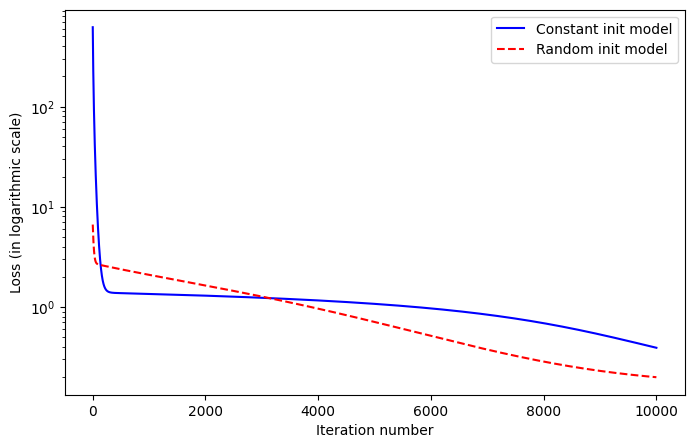

In [11]:
# Compare training curves
fig = plt.figure(figsize = (8, 5))
plt.plot(list(range(len(shallow_neural_net_const.losses_list))), \
            shallow_neural_net_const.losses_list, \
            "b", label = "Constant init model")
plt.plot(list(range(len(shallow_neural_net_rand.losses_list))), \
            shallow_neural_net_rand.losses_list, \
            "r--", label = "Random init model")
plt.xlabel("Iteration number")
plt.ylabel("Loss (in logarithmic scale)")
plt.yscale("log")
# Display
plt.legend(loc = "best")
plt.show()

### Which initialization is best then?

We have observed that a constant initialization is usually not a good idea, as it does not break symmetry. For this reason, it is often preferable to have some variance in the parameters and vectors produced during the **forward()** operations?

This, however, raises an important question: **which initialization method is best and should be used?**

In general, four initialization methods are considered in Neural Networks.

1. **The Normal Random initialization:** One simple approach is to initialize the weights of the network to random values drawn from a Gaussian distribution with a mean of 0 and a standard deviation of 0.01 or 0.1. This is a simple and effective method, but it can be sensitive to the choice of standard deviation, and was typically implemented in our original design 

```
self.W1 = np.random.randn(n_x, n_h)*0.1
self.b1 = np.random.randn(1, n_h)*0.1
self.W2 = np.random.randn(n_h, n_y)*0.1
self.b2 = np.random.randn(1, n_y)*0.1
```

2. **Xavier initialization:** Another popular method is Xavier initialization, which is designed to preserve the variance of the activations of the network as the weights are updated during training. This initialization technique is generally used for large networks with sigmoid or tanh activation functions and can help improve the convergence of the network. This would typically be implemented using a uniform distribution, as shown below:

```
# To ensure the variance is 1, we divide the range by the square root of the number of inputs
init_val = np.sqrt(6.0/(n_x + n_y))
self.W1 = np.random.uniform(-init_val, init_val, (n_x, n_h))
self.b1 = np.random.uniform(-init_val, init_val, (1, n_h))
self.W2 = np.random.uniform(-init_val, init_val, (n_h, n_y))
self.b2 = np.random.uniform(-init_val, init_val, (1, n_y))
```

It can also be implemented using a normal distribution, as shown below:
```
# To ensure the variance is 1, we divide the standard deviation by the square root of the number of inputs
std_dev = np.sqrt(3.0 / (input_size + output_size))
self.W1 = np.random.normal(0, std_dev, (n_x, n_h))
self.b1 = np.random.normal(0, std_dev, (1, n_h))
self.W2 = np.random.normal(0, std_dev, (n_h, n_y))
self.b2 = np.random.normal(0, std_dev, (1, n_y))
```

3. **He initialization:** Similar to Xavier initialization, He initialization is designed to preserve the variance of the activations, but it is specifically designed for large networks with ReLU activation functions. This would typically be implemented using a random normal for weights and zeroes for biases, as shown below:
```
range1 = np.sqrt(2/n_x)
self.W1 = np.random.randn(n_x, n_h)*range1
self.b1 = np.zeros((1, n_h))
range2 = np.sqrt(2/n_h)
self.W2 = np.random.randn(n_h, n_y)*range2
self.b2 = np.zeros((1, n_y))
```

4. **LeCun initialization:** This initialization technique is similar to Xavier initialization, but it is specifically designed for networks with sigmoid activation functions. It can be a good choice for networks with sigmoid activations and small networks. This would typically be implemented as:

```
range1 = np.sqrt(1/n_x)
self.W1 = np.random.randn(n_x, n_h)*range1
self.b1 = np.zeros((1, n_h))
range2 = np.sqrt(1/n_h)
self.W2 = np.random.randn(n_h, n_y)*range2
self.b2 = np.zeros((1, n_y))
```

**Important note:** these are empirical observations only. For this reason, it is a good idea to try a few different initialization techniques and see which one works best for your particular network architecture and dataset. Some recent research has also suggested that using a combination of different initialization techniques (e.g., random initialization for some layers and He initialization for others) can improve performance.

We will conclude this notebook by amending the **ShallowNeuralNet** class and bring in five additional methods for each possible initialization method and leave it to the reader to play with the different types of initializations to see their effects.

In [13]:
class ShallowNeuralNet():
    
    def __init__(self, n_x, n_h, n_y, init_type = "Normal"):
        # Network dimensions
        self.n_x = n_x
        self.n_h = n_h
        self.n_y = n_y
        # Initialize parameters
        self.init_type = init_type
        self.init_parameters()
        # Loss, initialized as infinity before first calculation is made
        self.loss = float("Inf")
        
    def init_parameters(self):
        if(self.init_type == "Normal"):
            self.init_parameters_normal()
        elif(self.init_type == "Xavier"):
            self.init_parameters_xavier()
        elif(self.init_type == "He"):
            self.init_parameters_he()
        elif(self.init_type == "LeCun"):
            self.init_parameters_lecun()
        elif(self.init_type == "Constant"):
            self.init_parameters_const()
        else:
            assert False, "Invalid initialization of parameters, check your init_type."
            
    def init_parameters_normal(self):
        # Weights and biases matrices (randomly initialized)
        self.W1 = np.random.randn(self.n_x, self.n_h)*0.1
        self.b1 = np.random.randn(1, self.n_h)*0.1
        self.W2 = np.random.randn(self.n_h, self.n_y)*0.1
        self.b2 = np.random.randn(1, self.n_y)*0.1
        
    def init_parameters_xavier(self):
        # Weights and biases matrices (Xavier initialized)
        init_val = np.sqrt(6.0/(self.n_x + self.n_y))
        self.W1 = np.random.uniform(-init_val, init_val, (self.n_x, self.n_h))
        self.b1 = np.random.uniform(-init_val, init_val, (1, self.n_h))
        self.W2 = np.random.uniform(-init_val, init_val, (self.n_h, self.n_y))
        self.b2 = np.random.uniform(-init_val, init_val, (1, self.n_y))
        
    def init_parameters_he(self):
        # Weights and biases matrices (He initialized)
        range1 = np.sqrt(2/self.n_x)
        self.W1 = np.random.randn(self.n_x, self.n_h)*range1
        self.b1 = np.zeros((1, self.n_h))
        range2 = np.sqrt(2/self.n_h)
        self.W2 = np.random.randn(self.n_h, self.n_y)*range2
        self.b2 = np.zeros((1, self.n_y))
        
    def init_parameters_lecun(self):
        # Weights and biases matrices (LeCun initialized)
        range1 = np.sqrt(1/self.n_x)
        self.W1 = np.random.randn(self.n_x, self.n_h)*range1
        self.b1 = np.zeros((1, self.n_h))
        range2 = np.sqrt(1/self.n_h)
        self.W2 = np.random.randn(self.n_h, self.n_y)*range2
        self.b2 = np.zeros((1, self.n_y))
        
    def init_parameters_const(self):
        # Weights and biases matrices (Constant initialized)
        const_val = 0.1
        self.W1 = np.ones(shape = (n_x, n_h))*const_val
        self.b1 = np.ones(shape = (1, n_h))*const_val
        self.W2 = np.ones(shape = (n_h, n_y))*const_val
        self.b2 = np.ones(shape = (1, n_y))*const_val
        
    def forward(self, inputs):
        # Wx + b operation for the first layer
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        # Wx + b operation for the second layer
        Z2 = np.matmul(Z1_b, self.W2)
        Z2_b = Z2 + self.b2
        return Z2_b
    
    def MSE_loss(self, inputs, outputs):
        # MSE loss function as before
        outputs_re = outputs.reshape(-1, 1)
        pred = self.forward(inputs)
        losses = (pred - outputs_re)**2
        self.loss = np.sum(losses)/outputs.shape[0]
        return self.loss
    
    def backward(self, inputs, outputs, alpha = 1e-5):
        # Get the number of samples in dataset
        m = inputs.shape[0]
        
        # Forward propagate
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        Z2 = np.matmul(Z1_b, self.W2)
        y_pred = Z2 + self.b2
    
        # Compute error term
        epsilon = y_pred - outputs
    
        # Compute the gradient for W2 and b2
        dL_dW2 = (2/m)*np.matmul(Z1_b.T, epsilon)
        dL_db2 = (2/m)*np.sum(epsilon, axis = 0, keepdims = True)

        # Compute the loss derivative with respect to the first layer
        dL_dZ1 = np.matmul(epsilon, self.W2.T)

        # Compute the gradient for W1 and b1
        dL_dW1 = (2/m)*np.matmul(inputs.T, dL_dZ1)
        dL_db1 = (2/m)*np.sum(dL_dZ1, axis = 0, keepdims = True)

        # Update the weights and biases using gradient descent
        self.W1 -= alpha*dL_dW1
        self.b1 -= alpha*dL_db1
        self.W2 -= alpha*dL_dW2
        self.b2 -= alpha*dL_db2
        
        # Update loss
        self.MSE_loss(inputs, outputs)
    
    def train(self, N_max = 1000, alpha = 1e-5, beta = 1e-5, display = True):
        # List of losses, starts with the current loss
        self.losses_list = [self.loss]
        # Repeat iterations
        for iteration_number in range(1, N_max + 1):
            # Backpropagate
            self.backward(inputs, outputs, alpha)
            new_loss = self.loss
            # Update losses list
            self.losses_list.append(new_loss)
            # Display
            if(display and iteration_number % (N_max//100) == 1):
                print("Iteration {} - Loss = {}".format(iteration_number, new_loss))
            # Check for beta value and early stop criterion
            difference = abs(self.losses_list[-1] - self.losses_list[-2])
            if(difference < beta):
                if(display):
                    print("Stopping early - loss evolution was less than beta.")
                break
        else:
            # Else on for loop will execute if break did not trigger
            if(display):
                print("Stopping - Maximal number of iterations reached.")
    
    def show_losses_over_training(self):
        # Initialize matplotlib
        fig, axs = plt.subplots(1, 2, figsize = (15, 5))
        axs[0].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[0].set_xlabel("Iteration number")
        axs[0].set_ylabel("Loss")
        axs[1].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[1].set_xlabel("Iteration number")
        axs[1].set_ylabel("Loss (in logarithmic scale)")
        axs[1].set_yscale("log")
        # Display
        plt.show()

### What's next?

Below, we are trying the different initializations we have implemented and check their final loss values.

While it seems that the Normal and Lecun behave nicely, we end up with NaN values for Xavier and He initializations. This NaN value is a typical symptom for a phenomenon called the **exploding gradient syndrom**, which we will investigate in the next notebook.

In [14]:
# Define neural network structure (random normal initialization)
n_x = 2
n_h = 4
n_y = 1
init_type = "Normal"
np.random.seed(37)
shallow_neural_net_rand = ShallowNeuralNet(n_x, n_h, n_y, init_type)
# Train and show final loss
shallow_neural_net_rand.train(N_max = 10000, alpha = 1e-6, beta = 1e-6, display = False)
print(shallow_neural_net_rand.loss)

0.19879750888125622


In [15]:
# Define neural network structure (Xavier initialization)
n_x = 2
n_h = 4
n_y = 1
init_type = "Xavier"
np.random.seed(37)
shallow_neural_net_rand = ShallowNeuralNet(n_x, n_h, n_y, init_type)
# Train and show final loss
shallow_neural_net_rand.train(N_max = 10000, alpha = 1e-6, beta = 1e-6, display = False)
print(shallow_neural_net_rand.loss)

nan


In [16]:
# Define neural network structure (He initialization)
n_x = 2
n_h = 4
n_y = 1
init_type = "He"
np.random.seed(37)
shallow_neural_net_rand = ShallowNeuralNet(n_x, n_h, n_y, init_type)
# Train and show final loss
shallow_neural_net_rand.train(N_max = 10000, alpha = 1e-6, beta = 1e-6, display = False)
print(shallow_neural_net_rand.loss)

nan


In [17]:
# Define neural network structure (LeCun initialization)
n_x = 2
n_h = 4
n_y = 1
init_type = "LeCun"
np.random.seed(37)
shallow_neural_net_rand = ShallowNeuralNet(n_x, n_h, n_y, init_type)
# Train and show final loss
shallow_neural_net_rand.train(N_max = 10000, alpha = 1e-6, beta = 1e-6, display = False)
print(shallow_neural_net_rand.loss)

0.19672435697959575


### What's next?

In the next notebook, we will investigate the exploding gradient problem that we have observed in the Xavier and He initialization.